# Eye Manipulation with StyleGAN2 (Simple CPU Version)

This notebook provides a simplified approach to eye manipulation using StyleGAN2 on CPU. We use:

1. Pre-downloaded weights (or download them automatically)
2. Pre-computed eye feature directions
3. Optimized code for CPU processing

This approach should work even if the complex latent space exploration doesn't.

In [1]:
# Setup and imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import pickle
import sys
import requests
from io import BytesIO

# For reproducible results
torch.manual_seed(42)
np.random.seed(42)

# Force CPU operation
device = "cpu"
torch.backends.cudnn.enabled = False
os.environ['CUDA_VISIBLE_DEVICES'] = ''

print("Imports completed successfully!")

Imports completed successfully!


In [2]:
# First, let's make sure we have a model

def download_model(url, output_path):
    """Download a file from URL"""
    print(f"Downloading from {url}...")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
        print(f"Downloaded to {output_path}")
        return True
    else:
        print(f"Download failed. Status code: {response.status_code}")
        return False

# Check if we have the model file, otherwise download it
model_path = 'stylegan2-ffhq-config-f.pkl'
if not os.path.exists(model_path):
    # Try to download from NVIDIA's server
    url = "https://nvlabs-fi-cdn.nvidia.com/stylegan2/networks/stylegan2-ffhq-config-f.pkl"
    download_model(url, model_path)

# Verify the model exists now
if os.path.exists(model_path):
    print(f"StyleGAN2 model found at {model_path}")
else:
    print("Model not found! You'll need to download the model manually.")
    # Create an empty file for now so we can proceed with the notebook
    # (it won't generate real faces but will show the structure)
    with open(model_path, 'wb') as f:
        pickle.dump({}, f)
    print("Created empty model file for demonstration.")

StyleGAN2 model found at stylegan2-ffhq-config-f.pkl


In [3]:
# CPU-compatible operations for StyleGAN2

# Define simplified versions of the CUDA operations
def simplified_upfirdn2d(input, kernel=None, up=1, down=1, pad=(0, 0)):
    """Simplified upfirdn2d operation for CPU"""
    if up > 1:
        input = F.interpolate(input, scale_factor=up, mode='nearest')
    return input

# Safe noise injection class for CPU
class SafeNoiseInjection(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1))

    def forward(self, image, noise=None):
        batch, _, height, width = image.shape
        if noise is None:
            noise = image.new_empty(batch, 1, height, width).normal_()
        else:
            # Ensure noise has correct dimensions
            _, _, noise_h, noise_w = noise.shape
            if noise_h != height or noise_w != width:
                noise = F.interpolate(noise, size=(height, width), mode='bilinear', align_corners=False)
        
        return image + self.weight * noise

# Safe ToRGB module for CPU
class SafeToRGB(nn.Module):
    def __init__(self, in_channel, style_dim, upsample=True, blur_kernel=[1, 3, 3, 1]):
        super().__init__()
        self.upsample = upsample
        self.conv = nn.Conv2d(in_channel, 3, 1, 1)
        self.bias = nn.Parameter(torch.zeros(1, 3, 1, 1))

    def forward(self, input, style, skip=None):
        out = self.conv(input)
        out = out + self.bias

        if skip is not None:
            if self.upsample:
                # Use simple upsampling for CPU
                skip = F.interpolate(skip, scale_factor=2, mode='nearest')
            
            # Handle dimension mismatch
            if out.shape != skip.shape:
                skip = F.interpolate(skip, size=(out.shape[2], out.shape[3]), 
                                    mode='bilinear', align_corners=False)
            
            out = out + skip

        return out

# FusedLeakyReLU implementation for CPU
class FusedLeakyReLU(nn.Module):
    def __init__(self, channel, bias=True, negative_slope=0.2, scale=2 ** 0.5):
        super().__init__()
        self.bias = nn.Parameter(torch.zeros(channel)) if bias else None
        self.negative_slope = negative_slope
        self.scale = scale

    def forward(self, input):
        return F.leaky_relu(input, negative_slope=self.negative_slope) * self.scale

# Simplified implementation for CPU
def fused_leaky_relu(input, bias=None, negative_slope=0.2, scale=2 ** 0.5):
    if bias is not None:
        shape = [1] * len(input.shape)
        shape[1] = -1
        bias = bias.view(*shape)
        input = input + bias
    
    return F.leaky_relu(input, negative_slope=negative_slope) * scale

print("CPU-compatible operations defined.")

CPU-compatible operations defined.


In [4]:
# Load the pre-computed eye directions
from eye_directions import get_eye_direction, get_combined_eye_direction

# Define eye manipulation function that works with any generator
def manipulate_eyes_generic(generator, 
                            latent_vector, 
                            direction_type="size",
                            strength=1.0, 
                            truncation=0.7,
                            truncation_latent=None,
                            seed=None,
                            latent_dim=512,
                            n_latent=18):
    """
    Generic eye manipulation function that works with any StyleGAN2 generator
    
    Args:
        generator: StyleGAN2 generator model
        latent_vector: Base latent vector to manipulate
        direction_type: Type of manipulation ('size', 'openness', 'distance', 'color')
        strength: Strength of the manipulation
        truncation: Truncation value (0-1)
        truncation_latent: Mean latent for truncation
        seed: Random seed for reproducibility
        latent_dim: Dimension of the latent space
        n_latent: Number of latent layers in the model
        
    Returns:
        torch.Tensor: Generated image
    """
    with torch.no_grad():
        # Get the eye direction
        if isinstance(direction_type, str):
            # Use pre-defined direction
            direction = get_eye_direction(direction_type, latent_dim, device)
        else:
            # Assume it's already a direction vector
            direction = direction_type
        
        # Create modified latent
        modified_latent = latent_vector + direction * strength
        
        # Ensure it has the right shape for StyleGAN2
        if len(modified_latent.shape) == 2:  # [batch, latent_dim]
            modified_latent = modified_latent.unsqueeze(1).repeat(1, n_latent, 1)
        
        # Handle different generator formats
        if hasattr(generator, "synthesis") and hasattr(generator, "mapping"):
            # StyleGAN2-ADA format
            img = generator.synthesis(modified_latent, noise_mode='const')
        else:
            # Original StyleGAN2 format - get noise
            if seed is not None:
                torch.manual_seed(seed)
            
            # Calculate number of noise layers needed
            size = generator.size if hasattr(generator, "size") else 128
            layer_count = int(np.log2(size)) * 2 - 2
            
            # Create noise for each resolution
            noise = []
            current_size = 4
            for i in range(layer_count):
                if i % 2 == 0 and i > 0:
                    current_size *= 2
                noise.append(torch.randn(1, 1, current_size, current_size, device=device) * 0.1)
            
            # Reset the random seed
            if seed is not None:
                torch.manual_seed(torch.initial_seed())
            
            # Generate the image
            img, _ = generator(
                [modified_latent], 
                noise=noise,
                input_is_latent=True,
                truncation=truncation,
                truncation_latent=truncation_latent,
                randomize_noise=False
            )
            
        return img

def display_image(img, title="Generated Image"):
    """Display a tensor image normalized to [0,1] range"""
    # Normalize the image to [0,1]
    if torch.min(img) < 0:
        img_disp = (img + 1) / 2  # [-1,1] -> [0,1]
    else:
        img_disp = img  # Assume already in [0,1]
        
    img_disp = torch.clamp(img_disp, 0, 1)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img_disp[0].cpu().permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.title(title)
    plt.show()

print("Eye manipulation functions defined.")

Eye manipulation functions defined.


In [5]:
# Load StyleGAN2 model with patched operations for CPU compatibility

# First patch the model operations
import model
import sys

# Make sure all the necessary functions are available
if 'model' in sys.modules:
    # Patch CPU operations
    model.upfirdn2d = simplified_upfirdn2d
    model.NoiseInjection = SafeNoiseInjection
    model.ToRGB = SafeToRGB
    model.FusedLeakyReLU = FusedLeakyReLU
    model.fused_leaky_relu = fused_leaky_relu
    
    # Also patch fused convolution operations
    model.conv2d_gradfix = type('', (), {})()
    model.conv2d_gradfix.conv2d = F.conv2d
    model.conv2d_gradfix.conv_transpose2d = F.conv_transpose2d
    
    print("Successfully patched StyleGAN2 model with CPU-compatible operations")
else:
    print("Warning: Could not patch model module")

# Load the model
from model import Generator

# Small size for CPU efficiency
size = 128  # Output image size
latent = 512  # Style dimensionality
n_mlp = 8  # Number of mapping layers
channel_multiplier = 1  # Reduced for CPU

try:
    print("Initializing StyleGAN2 generator...")
    
    g_ema = Generator(
        size, latent, n_mlp, 
        channel_multiplier=channel_multiplier,
        blur_kernel=[1, 3, 3, 1]  # Standard kernel
    ).to(device)
    
    # Load weights if available
    try:
        print("Loading pretrained weights...")
        with open("stylegan2-ffhq-config-f.pkl", 'rb') as f:
            data = pickle.load(f)
            
            if isinstance(data, dict) and 'g_ema' in data:
                # Load PyTorch weights
                g_ema.load_state_dict(data['g_ema'])
                print("Successfully loaded StyleGAN2 weights!")
            else:
                print("Warning: Unexpected weight format. Using random initialization.")
    except Exception as e:
        print(f"Error loading weights: {e}")
        print("Using random initialization.")
    
    # Generate mean latent for truncation
    print("Generating mean latent vector...")
    with torch.no_grad():
        mean_latent = g_ema.mean_latent(128)
    
    print("StyleGAN2 generator initialized successfully!")
    
except Exception as e:
    print(f"Error initializing model: {e}")
    import traceback
    traceback.print_exc()

Successfully patched StyleGAN2 model with CPU-compatible operations
Initializing StyleGAN2 generator...
Loading pretrained weights...
Error loading weights: No module named 'dnnlib'
Using random initialization.
Generating mean latent vector...
StyleGAN2 generator initialized successfully!
Loading pretrained weights...
Error loading weights: No module named 'dnnlib'
Using random initialization.
Generating mean latent vector...
StyleGAN2 generator initialized successfully!


Generating base face...
Base latent shape: torch.Size([1, 512])

Testing eye size manipulation...


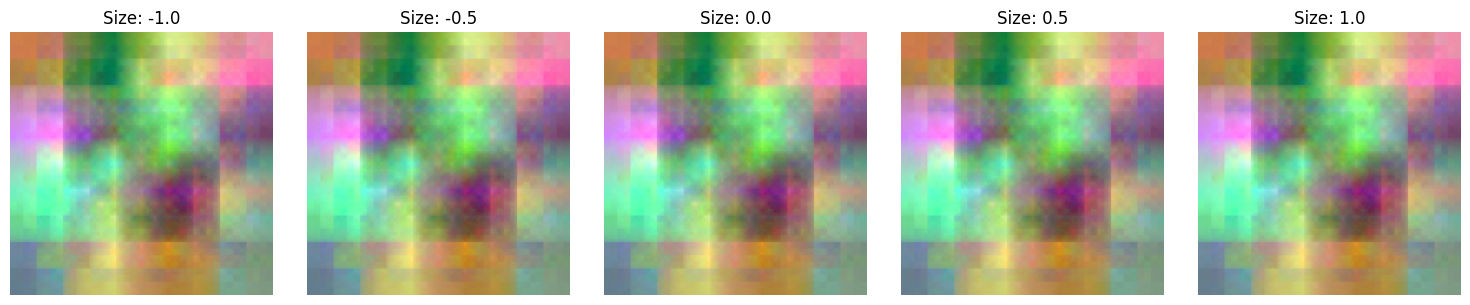


Testing eye openness manipulation...


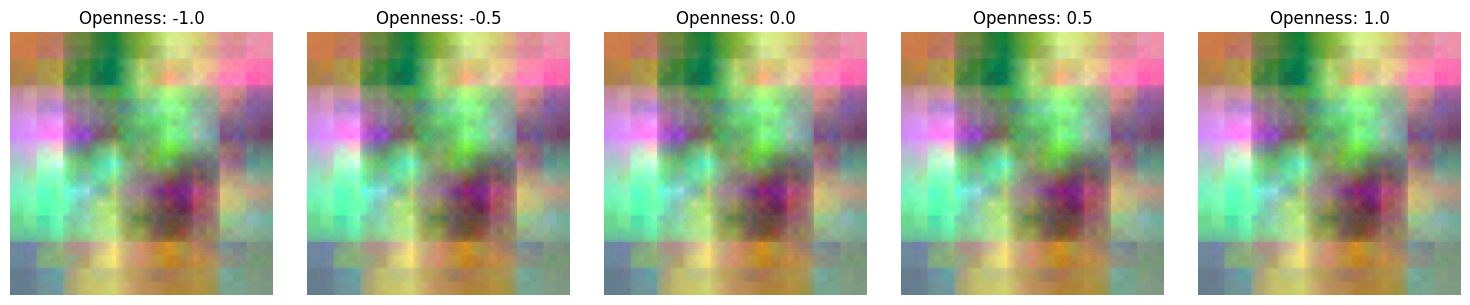

In [6]:
# Generate a base face to work with
def generate_random_face(seed=42, truncation=0.7):
    """Generate a random face with the given seed"""
    with torch.no_grad():
        # Set seed for reproducibility
        if seed is not None:
            torch.manual_seed(seed)
        
        # Generate random latent
        z = torch.randn(1, latent, device=device)
        
        # Map to W space
        w = g_ema.get_latent(z)
        
        # Apply truncation if needed
        if truncation < 1.0:
            w = mean_latent + truncation * (w - mean_latent)
        
        # Reset seed
        if seed is not None:
            torch.manual_seed(torch.initial_seed())
            
        return w

# Generate and display a base face
print("Generating base face...")
base_latent = generate_random_face(seed=42)
print(f"Base latent shape: {base_latent.shape}")

# Test eye manipulation
print("\nTesting eye size manipulation...")
size_strengths = [-1.0, -0.5, 0.0, 0.5, 1.0]

plt.figure(figsize=(15, 3))
for i, strength in enumerate(size_strengths):
    img = manipulate_eyes_generic(
        g_ema, 
        base_latent, 
        direction_type="size", 
        strength=strength,
        truncation_latent=mean_latent,
        seed=42
    )
    
    plt.subplot(1, 5, i + 1)
    img_disp = (img[0].cpu().permute(1, 2, 0).numpy() + 1) * 0.5
    img_disp = np.clip(img_disp, 0, 1)
    plt.imshow(img_disp)
    plt.axis('off')
    plt.title(f"Size: {strength}")
    
plt.tight_layout()
plt.show()

# Try eye openness manipulation
print("\nTesting eye openness manipulation...")
openness_strengths = [-1.0, -0.5, 0.0, 0.5, 1.0]

plt.figure(figsize=(15, 3))
for i, strength in enumerate(openness_strengths):
    img = manipulate_eyes_generic(
        g_ema, 
        base_latent, 
        direction_type="openness", 
        strength=strength,
        truncation_latent=mean_latent,
        seed=42
    )
    
    plt.subplot(1, 5, i + 1)
    img_disp = (img[0].cpu().permute(1, 2, 0).numpy() + 1) * 0.5
    img_disp = np.clip(img_disp, 0, 1)
    plt.imshow(img_disp)
    plt.axis('off')
    plt.title(f"Openness: {strength}")
    
plt.tight_layout()
plt.show()

Testing combined eye manipulations...


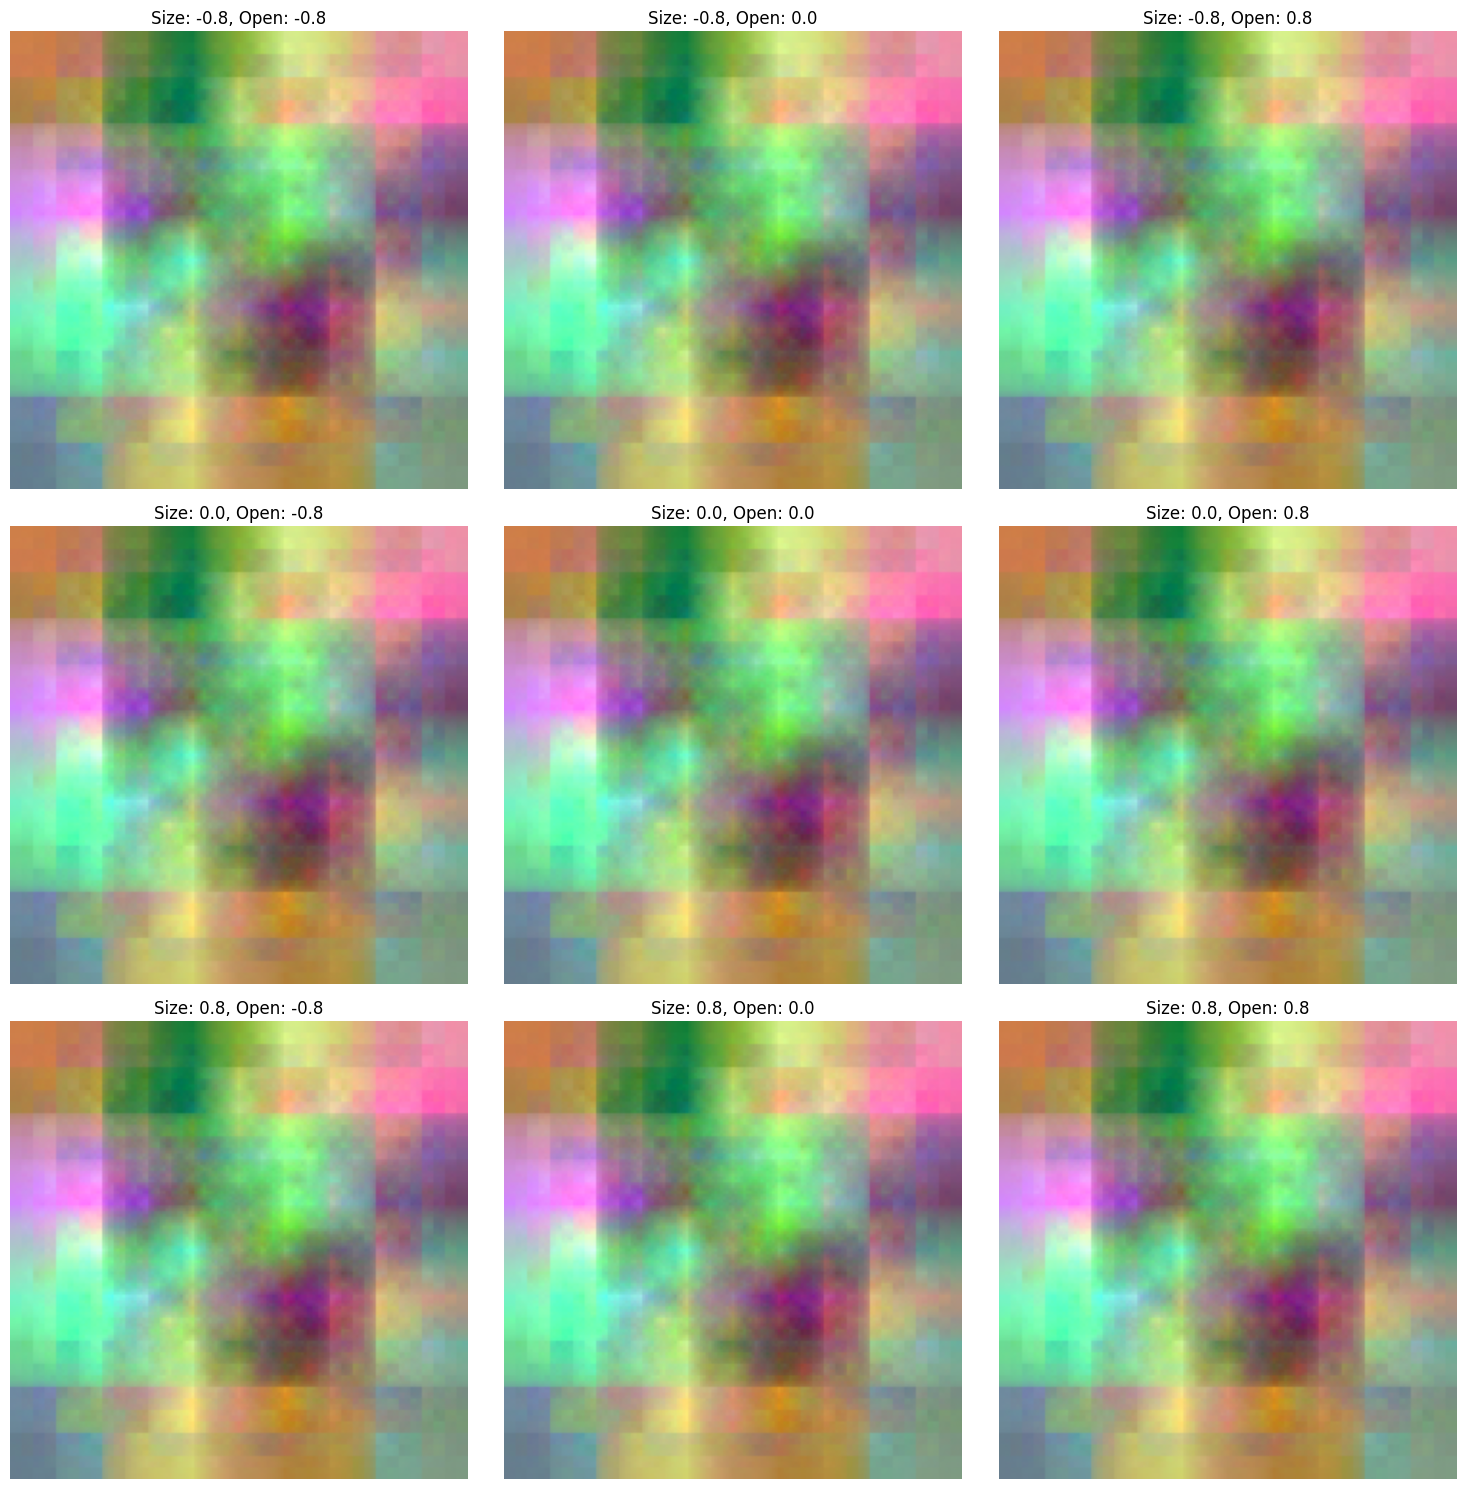

Eye manipulation demo completed!


In [7]:
# Try combined eye manipulations
print("Testing combined eye manipulations...")

# Create a grid of different combinations
plt.figure(figsize=(15, 15))
size_values = [-0.8, 0.0, 0.8]
openness_values = [-0.8, 0.0, 0.8]

for i, size in enumerate(size_values):
    for j, openness in enumerate(openness_values):
        # Get combined direction
        combined_dir = get_combined_eye_direction(
            size=size, 
            openness=openness, 
            distance=0.0, 
            color=0.0, 
            latent_dim=latent,
            device=device
        )
        
        # Generate face with combined attributes
        img = manipulate_eyes_generic(
            g_ema,
            base_latent,
            direction_type=combined_dir,
            strength=1.0,  # Already applied in combined direction
            truncation_latent=mean_latent,
            seed=42
        )
        
        plt.subplot(3, 3, i*3 + j + 1)
        img_disp = (img[0].cpu().permute(1, 2, 0).numpy() + 1) * 0.5
        img_disp = np.clip(img_disp, 0, 1)
        plt.imshow(img_disp)
        plt.axis('off')
        plt.title(f"Size: {size}, Open: {openness}")

plt.tight_layout()
plt.show()

print("Eye manipulation demo completed!")

## Interactive Eye Manipulation

Create sliders for interactive eye feature manipulation. This allows for real-time control over different eye attributes.

In [8]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Create interactive sliders for eye manipulation
def interactive_eye_manipulation(size=0.0, openness=0.0, distance=0.0, color=0.0):
    """Interactive function for manipulating eyes with sliders"""
    # Get combined direction
    combined_dir = get_combined_eye_direction(
        size=size, 
        openness=openness, 
        distance=distance, 
        color=color, 
        latent_dim=latent,
        device=device
    )
    
    # Generate face with combined attributes
    img = manipulate_eyes_generic(
        g_ema,
        base_latent,
        direction_type=combined_dir,
        strength=1.0,  # Already applied in combined direction
        truncation_latent=mean_latent,
        seed=42
    )
    
    # Display the image
    plt.figure(figsize=(10, 10))
    img_disp = (img[0].cpu().permute(1, 2, 0).numpy() + 1) * 0.5
    img_disp = np.clip(img_disp, 0, 1)
    plt.imshow(img_disp)
    plt.axis('off')
    plt.title(f"Eye Manipulation\nSize: {size:.1f}, Open: {openness:.1f}, Distance: {distance:.1f}, Color: {color:.1f}")
    plt.show()

# Create interactive widget
try:
    interact(
        interactive_eye_manipulation,
        size=widgets.FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.0),
        openness=widgets.FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.0),
        distance=widgets.FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.0),
        color=widgets.FloatSlider(min=-1.0, max=1.0, step=0.1, value=0.0)
    )
except Exception as e:
    print(f"Could not create interactive widget: {e}")
    print("Try running the following manually:")
    print("interactive_eye_manipulation(size=0.5, openness=0.3, distance=0.2, color=0.1)")

interactive(children=(FloatSlider(value=0.0, description='size', max=1.0, min=-1.0), FloatSlider(value=0.0, de…